[이하은] 기본 데이터셋을 사용하여(testset 제외) CNN 모델 baseline 구성.

구조 및 역할 : 
- Conv + Pooling: 이미지에서 점점 복잡한 특징 추출
- Flatten + Dense: 추출된 특징들을 바탕으로 분류
- Softmax 출력층: 6개 해파리 종류 중 하나로 최종 예측


## 1. 데이터 로딩

In [2]:
import tensorflow as tf

IMG_SIZE = 224
BATCH_SIZE = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    "/aiffel/aiffel/jellyfish/Train_Test_Valid/Train",
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    "/aiffel/aiffel/jellyfish/Train_Test_Valid/valid",
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    "/aiffel/aiffel/jellyfish/Train_Test_Valid/test",
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)

# 데이터 최적화(성능 향상)
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE) # 한 번 읽은 데이터는 메모리에 저장하여 재사용, 학습 순서를 섰어 편향 학습 방지. 
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE) # 학습 도중 다음 배치 미리 준비 -> 병럴 처리로 GPU 효율 증가.
# test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)


Found 900 files belonging to 6 classes.
Found 39 files belonging to 6 classes.
Found 40 files belonging to 6 classes.


## 2. baseline CNN 모델 정의

In [3]:
from tensorflow.keras import layers, models

model_1 = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(6, activation='softmax')  # 클래스 수 = 6
])


## 3. 컴파일 및 학습

In [6]:
from tensorflow.keras.callbacks import ModelCheckpoint

# 콜백 설정: val_accuracy 기준으로 최고 성능 모델 저장
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', 
                             save_best_only=True, mode='max', verbose=1)

model_1.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy', # 분류 문제 때 사용
              metrics=['accuracy']) # 정확도를 측정

history = model_1.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    callbacks=[checkpoint]
)


Epoch 1/15
29/29 [==============================] - 6s 52ms/step - loss: 599.2233 - accuracy: 0.2544 - val_loss: 1.8635 - val_accuracy: 0.3077

Epoch 00001: val_accuracy improved from -inf to 0.30769, saving model to best_model.h5
Epoch 2/15
29/29 [==============================] - 1s 39ms/step - loss: 1.3253 - accuracy: 0.5133 - val_loss: 1.9733 - val_accuracy: 0.3333

Epoch 00002: val_accuracy improved from 0.30769 to 0.33333, saving model to best_model.h5
Epoch 3/15
29/29 [==============================] - 1s 40ms/step - loss: 0.9035 - accuracy: 0.6967 - val_loss: 2.4481 - val_accuracy: 0.3333

Epoch 00003: val_accuracy did not improve from 0.33333
Epoch 4/15
29/29 [==============================] - 1s 38ms/step - loss: 0.5551 - accuracy: 0.8467 - val_loss: 3.5955 - val_accuracy: 0.3590

Epoch 00004: val_accuracy improved from 0.33333 to 0.35897, saving model to best_model.h5
Epoch 5/15
29/29 [==============================] - 1s 39ms/step - loss: 0.3179 - accuracy: 0.9111 - val_los

## 4. 학습 결과 시각화
- 결과 : 
- 7 에포크가 최대 성능.
- 간단한 모델인만큼 빠른 과대적합.

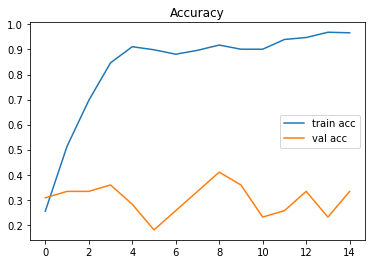

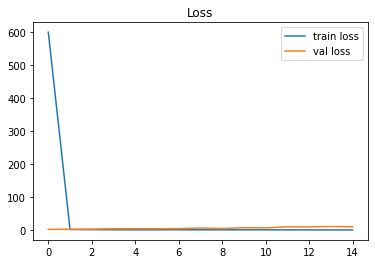

In [7]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.title('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.legend()
plt.show()


In [8]:
test_loss, test_acc = model_1.evaluate(test_ds)
print(f"Test accuracy: {test_acc:.4f}, Test loss: {test_loss:.4f}")

2/2 [==============================] - 0s 146ms/step - loss: 7.4449 - accuracy: 0.3250
Test accuracy: 0.3250, Test loss: 7.4449


                         precision    recall  f1-score   support

         Moon_jellyfish       0.40      0.67      0.50         6
       barrel_jellyfish       0.25      0.40      0.31         5
         blue_jellyfish       0.25      0.14      0.18         7
      compass_jellyfish       0.00      0.00      0.00         7
   lions_mane_jellyfish       0.00      0.00      0.00         8
mauve_stinger_jellyfish       0.43      0.86      0.57         7

               accuracy                           0.33        40
              macro avg       0.22      0.34      0.26        40
           weighted avg       0.21      0.33      0.25        40



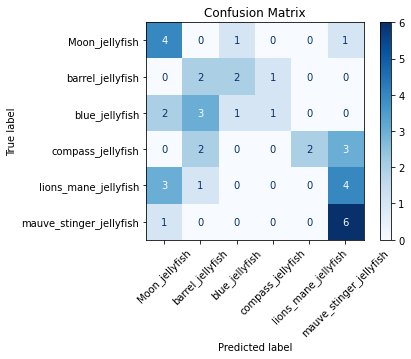

In [9]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 예측 수행
y_pred = []
y_true = []

for images, labels in test_ds:
    preds = model_1.predict(images, verbose=0)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(labels.numpy())

# 클래스 이름 (Dataset에서 자동 인식된 순서)
class_names = test_ds.class_names

# Classification Report 출력
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion Matrix 시각화
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(xticks_rotation=45, cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


## - 베이스라인 성능 향상 시도
1. 모델 깊이 증가
2. Dropout 추가
3. Batch Nornalization 추가
4. ...

In [10]:
# 모델의 깊이를 증가 시키기 - conv 레이어 2배로 늘리기.
from tensorflow.keras import layers, models

model_2 = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(6, activation='softmax')  # 클래스 수 = 6
])

In [11]:
from tensorflow.keras.callbacks import ModelCheckpoint

# 콜백 설정: val_accuracy 기준으로 최고 성능 모델 저장
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', 
                             save_best_only=True, mode='max', verbose=1)

model_2.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy', # 분류 문제 때 사용
              metrics=['accuracy']) # 정확도를 측정

history = model_2.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    callbacks=[checkpoint]
)

Epoch 1/15
29/29 [==============================] - 2s 44ms/step - loss: 4.7615 - accuracy: 0.2033 - val_loss: 1.7388 - val_accuracy: 0.1282

Epoch 00001: val_accuracy improved from -inf to 0.12821, saving model to best_model.h5
Epoch 2/15
29/29 [==============================] - 1s 32ms/step - loss: 1.6290 - accuracy: 0.3289 - val_loss: 1.7203 - val_accuracy: 0.3590

Epoch 00002: val_accuracy improved from 0.12821 to 0.35897, saving model to best_model.h5
Epoch 3/15
29/29 [==============================] - 1s 32ms/step - loss: 1.3361 - accuracy: 0.4922 - val_loss: 1.8692 - val_accuracy: 0.2821

Epoch 00003: val_accuracy did not improve from 0.35897
Epoch 4/15
29/29 [==============================] - 1s 32ms/step - loss: 1.0892 - accuracy: 0.6189 - val_loss: 3.1076 - val_accuracy: 0.2564

Epoch 00004: val_accuracy did not improve from 0.35897
Epoch 5/15
29/29 [==============================] - 1s 32ms/step - loss: 0.8072 - accuracy: 0.7189 - val_loss: 3.2469 - val_accuracy: 0.4103

Epo

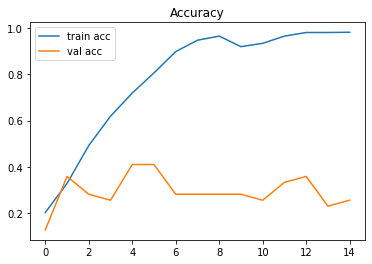

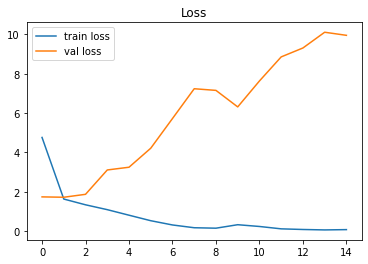

In [12]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.title('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.legend()
plt.show()

In [13]:
test_loss, test_acc = model_2.evaluate(test_ds)
print(f"Test accuracy: {test_acc:.4f}, Test loss: {test_loss:.4f}")

2/2 [==============================] - 0s 127ms/step - loss: 4.6169 - accuracy: 0.4500
Test accuracy: 0.4500, Test loss: 4.6169


                         precision    recall  f1-score   support

         Moon_jellyfish       0.44      0.67      0.53         6
       barrel_jellyfish       0.43      0.60      0.50         5
         blue_jellyfish       0.38      0.43      0.40         7
      compass_jellyfish       0.33      0.43      0.38         7
   lions_mane_jellyfish       0.75      0.38      0.50         8
mauve_stinger_jellyfish       0.67      0.29      0.40         7

               accuracy                           0.45        40
              macro avg       0.50      0.46      0.45        40
           weighted avg       0.51      0.45      0.45        40



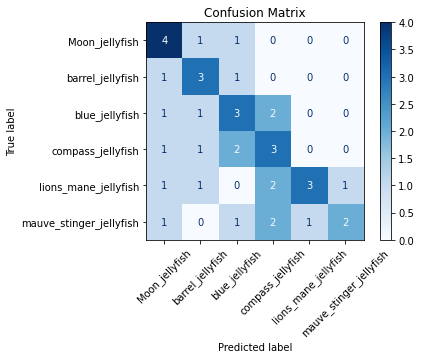

In [14]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 예측 수행
y_pred = []
y_true = []

for images, labels in test_ds:
    preds = model_2.predict(images, verbose=0)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(labels.numpy())

# 클래스 이름 (Dataset에서 자동 인식된 순서)
class_names = test_ds.class_names

# Classification Report 출력
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion Matrix 시각화
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(xticks_rotation=45, cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

In [17]:
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

model_8 = models.Sequential([
    # 0~255 픽셀을 0~1로 정규화
    layers.Rescaling(1./255, input_shape=(IMG_SIZE, IMG_SIZE, 3)),

    # 첫 번째 블록
    layers.Conv2D(32, (3,3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2,2)),

    # 두 번째 블록
    layers.Conv2D(64, (3,3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2,2)),

    # 세 번째 블록 추가 (새로 추가)
    layers.Conv2D(128, (3,3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2,2)),

    # Fully connected layers
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),  # dropout 다시 활성화 (오버피팅 방지)
    layers.Dense(6, activation='softmax')  # 클래스 수: 6개
])

# 컴파일
model_8.compile(
    optimizer=Adam(learning_rate=1e-4),  # 학습률 낮춤
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [18]:
from tensorflow.keras.callbacks import ModelCheckpoint

# 콜백 설정: val_accuracy 기준으로 최고 성능 모델 저장
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', 
                             save_best_only=True, mode='max', verbose=1)

history = model_8.fit(
    train_ds,
    validation_data=val_ds,
    epochs=35,
    callbacks=[checkpoint]
)

Epoch 1/35
29/29 [==============================] - 3s 75ms/step - loss: 2.9440 - accuracy: 0.3278 - val_loss: 1.7877 - val_accuracy: 0.1795

Epoch 00001: val_accuracy improved from -inf to 0.17949, saving model to best_model.h5
Epoch 2/35
29/29 [==============================] - 2s 66ms/step - loss: 1.3440 - accuracy: 0.4711 - val_loss: 1.7756 - val_accuracy: 0.2308

Epoch 00002: val_accuracy improved from 0.17949 to 0.23077, saving model to best_model.h5
Epoch 3/35
29/29 [==============================] - 2s 66ms/step - loss: 1.1399 - accuracy: 0.5389 - val_loss: 1.7992 - val_accuracy: 0.2051

Epoch 00003: val_accuracy did not improve from 0.23077
Epoch 4/35
29/29 [==============================] - 2s 66ms/step - loss: 0.9690 - accuracy: 0.6289 - val_loss: 1.8133 - val_accuracy: 0.1026

Epoch 00004: val_accuracy did not improve from 0.23077
Epoch 5/35
29/29 [==============================] - 2s 66ms/step - loss: 0.8842 - accuracy: 0.6611 - val_loss: 1.7468 - val_accuracy: 0.1795

Epo

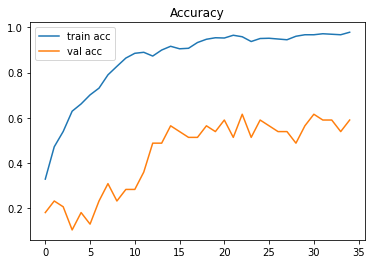

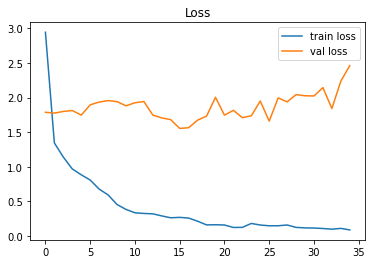

In [19]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.title('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.legend()
plt.show()

## 5. testset 평가(일단 생략)

In [20]:
test_loss, test_acc = model_8.evaluate(test_ds)
print(f"Test accuracy: {test_acc:.4f}, Test loss: {test_loss:.4f}")

2/2 [==============================] - 0s 160ms/step - loss: 1.5147 - accuracy: 0.7000
Test accuracy: 0.7000, Test loss: 1.5147


                         precision    recall  f1-score   support

         Moon_jellyfish       0.80      0.67      0.73         6
       barrel_jellyfish       0.50      1.00      0.67         5
         blue_jellyfish       1.00      0.57      0.73         7
      compass_jellyfish       0.62      0.71      0.67         7
   lions_mane_jellyfish       0.67      0.75      0.71         8
mauve_stinger_jellyfish       1.00      0.57      0.73         7

               accuracy                           0.70        40
              macro avg       0.77      0.71      0.70        40
           weighted avg       0.78      0.70      0.70        40



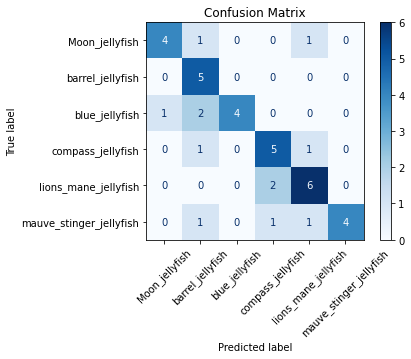

In [21]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 예측 수행
y_pred = []
y_true = []

for images, labels in test_ds:
    preds = model_8.predict(images, verbose=0)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(labels.numpy())

# 클래스 이름 (Dataset에서 자동 인식된 순서)
class_names = test_ds.class_names

# Classification Report 출력
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion Matrix 시각화
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(xticks_rotation=45, cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

## 기본 CNN 구조로 매우 작은 데이터셋을 학습하는데의 한계점을 느껴, 사전 훈련된 모델 불러오기
- ConvNeXt

In [ ]:
!pip install torch torchvision torchaudio

In [ ]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())

In [ ]:
!pip install timm

In [ ]:
!pip install huggingface_hub

In [ ]:
pip install --upgrade \
  torch==1.13.1+cu116 \
  torchvision==0.14.1+cu116 \
  torchaudio==0.13.1 \
  --extra-index-url https://download.pytorch.org/whl/cu116

In [ ]:
import timm

model = timm.create_model('convnext_tiny', pretrained=True)
print(model)